In [156]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from statsmodels.stats.multitest import multipletests
import warnings
import json
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
from datetime import datetime
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Configuration

In [157]:
# =============================================================================
# CONFIGURATION - Modify these paths as needed
# =============================================================================

# Data paths
SYNTHETIC_DATA_PATH = '/home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/synthetic_likely_normal_enhanced_smote.csv'
REAL_DATA_PATH = '/home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_discovered.csv'

# Output directory for results
OUTPUT_DIR = '/home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal/'
# Random seed for reproducibility
RANDOM_SEED = 42

# Significance level for statistical tests
ALPHA = 0.05

# Columns to exclude from analysis
EXCLUDE_COLS = ['sequence_id', 'timestep', 'label', 'window_start', 'window_end', 'discovered_label']

# KS statistic thresholds (for large sample interpretation)
KS_EXCELLENT_THRESHOLD = 0.05  # Very similar distributions
KS_GOOD_THRESHOLD = 0.10       # Reasonably similar
KS_MODERATE_THRESHOLD = 0.15   # Moderate similarity

# Cohen's d cap for numeric stability
COHENS_D_CAP = 10.0  # Cap extreme values

print("Configuration set!")

Configuration set!


## 2. Load and Prepare Data

In [158]:
# Load datasets
synthetic_full = pd.read_csv(SYNTHETIC_DATA_PATH)
real_full = pd.read_csv(REAL_DATA_PATH)

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nSynthetic Data Shape: {synthetic_full.shape}")
print(f"Real Data Shape: {real_full.shape}")
print(f"\nSynthetic Labels:\n{synthetic_full['label'].value_counts()}")
print(f"\nReal Labels:\n{real_full['discovered_label'].value_counts()}")

DATASET OVERVIEW

Synthetic Data Shape: (20000, 32)
Real Data Shape: (86400, 38)

Synthetic Labels:
label
synthetic    20000
Name: count, dtype: int64

Real Labels:
discovered_label
likely_normal              65819
uncertain                  14249
high_confidence_anomaly     4565
likely_anomaly              1767
Name: count, dtype: int64


In [159]:
# Filter only normal traffic from both datasets
synthetic_normal = synthetic_full[synthetic_full['label'] == 'synthetic'].copy()
real_normal = real_full[real_full['discovered_label'] == 'likely_normal'].copy()

print(f"Synthetic Normal samples: {len(synthetic_normal)}")
print(f"Real Normal samples: {len(real_normal)}")

Synthetic Normal samples: 20000
Real Normal samples: 65819


In [160]:
# Sample equal amounts for fair comparison
n_samples = min(len(synthetic_normal), len(real_normal))
print(f"\nUsing {n_samples} samples from each dataset for comparison")

# Use all synthetic normal (smaller dataset)
synthetic_sampled = synthetic_normal.copy()

# Random sample from real data
np.random.seed(RANDOM_SEED)
real_sampled = real_normal.sample(n=n_samples, random_state=RANDOM_SEED).copy()

print(f"Synthetic sampled: {len(synthetic_sampled)}")
print(f"Real sampled: {len(real_sampled)}")


Using 20000 samples from each dataset for comparison
Synthetic sampled: 20000
Real sampled: 20000


In [161]:
# Get feature columns
feature_cols = [col for col in synthetic_sampled.columns if col not in EXCLUDE_COLS]
print(f"\nNumber of features to compare: {len(feature_cols)}")
print(f"\nFeatures: {feature_cols}")
EXCLUDE_COLS = ['sequence_id', 'timestep', 'label' , 'window_start', 'window_end', 'discovered_label', 'generation_method', 'log_transform_used', 'bgp_constraints_enforced']  # plus any others you already had

feature_cols = [col for col in synthetic_sampled.columns if col not in EXCLUDE_COLS]
print(f"\nNumber of features to compare: {len(feature_cols)}")
print(f"\nFeatures: {feature_cols}")



Number of features to compare: 30

Features: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'nadas', 'flaps', 'edit_distance_avg', 'rare_ases_avg', 'generation_method', 'log_transform_used', 'bgp_constraints_enforced']

Number of features to compare: 27

Features: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5

In [162]:
# Get feature columns (exclude metadata columns)
feature_cols = [col for col in synthetic_sampled.columns if col not in EXCLUDE_COLS]

# IMPROVED: Comprehensive constant feature handling
# - Constant in both: exclude from analysis (no information)
# - Constant in synthetic only: FLAG as GAN issue (not learning variance)
# - Constant in real only: FLAG as data artifact (rare)
constant_both = []
constant_synthetic_only = []  # Potential GAN issue
constant_real_only = []       # Potential data issue
valid_features = []

for col in feature_cols:
    syn_std = synthetic_sampled[col].std()
    real_std = real_sampled[col].std()
    
    if syn_std == 0 and real_std == 0:
        constant_both.append(col)
    elif syn_std == 0 and real_std > 0:
        constant_synthetic_only.append({
            'feature': col, 
            'real_std': real_std, 
            'real_mean': real_sampled[col].mean(),
            'syn_value': synthetic_sampled[col].iloc[0]
        })
    elif syn_std > 0 and real_std == 0:
        constant_real_only.append({
            'feature': col, 
            'syn_std': syn_std, 
            'syn_mean': synthetic_sampled[col].mean(),
            'real_value': real_sampled[col].iloc[0]
        })
    else:
        valid_features.append(col)

print(f"Total feature columns: {len(feature_cols)}")
print(f"\n" + "=" * 60)
print("🔍 CONSTANT FEATURE ANALYSIS")
print("=" * 60)

print(f"\n✓ Constant in BOTH datasets (excluded - no information): {len(constant_both)}")
if constant_both:
    print(f"   Features: {constant_both}")

print(f"\n⚠️  Constant in SYNTHETIC only (GAN issue - not learning variance): {len(constant_synthetic_only)}")
if constant_synthetic_only:
    for item in constant_synthetic_only:
        print(f"   • {item['feature']}:")
        print(f"     - Synthetic: constant at {item['syn_value']:.4f}")
        print(f"     - Real: mean={item['real_mean']:.4f}, std={item['real_std']:.4f}")
    print(f"   ⚠️  ACTION NEEDED: GAN is not learning variance for these features!")

print(f"\n⚠️  Constant in REAL only (unusual - check data): {len(constant_real_only)}")
if constant_real_only:
    for item in constant_real_only:
        print(f"   • {item['feature']}:")
        print(f"     - Real: constant at {item['real_value']:.4f}")
        print(f"     - Synthetic: mean={item['syn_mean']:.4f}, std={item['syn_std']:.4f}")

# Store problematic features for final report
problematic_features = {
    'constant_both': constant_both,
    'constant_synthetic_only': constant_synthetic_only,
    'constant_real_only': constant_real_only
}

# Use only fully valid features for main analysis
feature_cols = valid_features
print(f"\n✓ Valid features for statistical comparison: {len(feature_cols)}")
print(f"   Features: {feature_cols}")

Total feature columns: 27

🔍 CONSTANT FEATURE ANALYSIS

✓ Constant in BOTH datasets (excluded - no information): 0

⚠️  Constant in SYNTHETIC only (GAN issue - not learning variance): 0

⚠️  Constant in REAL only (unusual - check data): 0

✓ Valid features for statistical comparison: 27
   Features: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'nadas', 'flaps', 'edit_distance_avg', 'rare_ases_avg']


In [163]:
# Extract feature matrices
X_synthetic = synthetic_sampled[feature_cols].values
X_real = real_sampled[feature_cols].values

# Create DataFrames for analysis
df_synthetic = synthetic_sampled[feature_cols].copy()
df_real = real_sampled[feature_cols].copy()

print(f"Synthetic feature matrix shape: {X_synthetic.shape}")
print(f"Real feature matrix shape: {X_real.shape}")

Synthetic feature matrix shape: (20000, 27)
Real feature matrix shape: (20000, 27)


## 3. Descriptive Statistics Comparison

In [164]:
# Calculate descriptive statistics for both datasets
stats_synthetic = df_synthetic.describe().T
stats_real = df_real.describe().T

# Rename columns for clarity
stats_synthetic.columns = [f'syn_{col}' for col in stats_synthetic.columns]
stats_real.columns = [f'real_{col}' for col in stats_real.columns]

# Combine into comparison table
stats_comparison = pd.concat([stats_synthetic, stats_real], axis=1)

# Reorder columns for side-by-side comparison
ordered_cols = []
for stat in ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    ordered_cols.extend([f'syn_{stat}', f'real_{stat}'])
stats_comparison = stats_comparison[ordered_cols]
stats_comparison.to_csv(f'{OUTPUT_DIR}/improved_v2_descriptive_stats_synthetic_SMOTE.csv')

print("Descriptive Statistics Comparison (Synthetic vs Real)")
print("=" * 80)
stats_comparison

Descriptive Statistics Comparison (Synthetic vs Real)


,syn_count,real_count,syn_mean,real_mean,syn_std,real_std,syn_min,real_min,syn_25%,real_25%,syn_50%,real_50%,syn_75%,real_75%,syn_max,real_max
announcements,20000.0,20000.0,99.979050,193.266600,165.470006,213.800219,3.000000,12.000000,20.000000,85.000000,40.000000,127.000000,88.000000,212.000000,1083.000000,2111.000000
withdrawals,20000.0,20000.0,4.520100,19.293700,6.193102,39.513553,0.000000,0.000000,1.000000,5.000000,2.000000,9.000000,6.000000,17.000000,70.000000,500.000000
nlri_ann,20000.0,20000.0,99.979050,193.266600,165.470006,213.800219,3.000000,12.000000,20.000000,85.000000,40.000000,127.000000,88.000000,212.000000,1083.000000,2111.000000
dups,20000.0,20000.0,1.649750,11.452000,2.636346,12.637491,0.000000,0.000000,0.000000,4.000000,1.000000,8.000000,2.000000,15.000000,28.000000,191.000000
origin_0,20000.0,20000.0,82.786500,184.696100,160.522613,200.662408,0.000000,8.000000,11.000000,82.000000,23.000000,122.000000,60.000000,204.000000,1047.000000,1961.000000
origin_2,20000.0,20000.0,17.036200,7.871400,21.615734,19.090047,0.000000,0.000000,5.000000,0.000000,10.000000,2.000000,22.000000,6.000000,432.000000,252.000000
origin_changes,20000.0,20000.0,2.983250,1.243700,4.049628,2.654894,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,41.000000,52.000000
imp_wd,20000.0,20000.0,4.103200,21.069250,4.384485,17.282390,0.000000,0.000000,1.000000,11.000000,3.000000,17.000000,5.000000,26.000000,44.000000,232.000000
imp_wd_spath,20000.0,20000.0,0.914600,6.063950,1.914338,6.650359,0.000000,0.000000,0.000000,2.000000,0.000000,4.000000,1.000000,8.000000,29.000000,102.000000
imp_wd_dpath,20000.0,20000.0,3.131400,15.005300,3.549812,14.647409,0.000000,0.000000,1.000000,7.000000,2.000000,11.000000,4.000000,18.000000,43.000000,228.000000


In [165]:
# IMPROVED: Mean Difference Analysis with better edge case handling
mean_diff = pd.DataFrame({
    'synthetic_mean': df_synthetic.mean(),
    'real_mean': df_real.mean()
})
mean_diff['abs_diff'] = abs(mean_diff['synthetic_mean'] - mean_diff['real_mean'])

# IMPROVED: Handle edge cases where real_mean is near zero
MIN_MEANINGFUL_VALUE = 0.01
mean_diff['pct_diff'] = np.where(
    mean_diff['real_mean'].abs() > MIN_MEANINGFUL_VALUE,
    (mean_diff['abs_diff'] / mean_diff['real_mean'].abs()) * 100,
    np.where(
        mean_diff['abs_diff'] < MIN_MEANINGFUL_VALUE,
        0.0,  # Both near zero = no meaningful difference
        np.nan  # Real is ~0 but synthetic is not = undefined percentage
    )
)

mean_diff = mean_diff.sort_values('pct_diff', ascending=False)
mean_diff.to_csv(f'{OUTPUT_DIR}/improved_v2_mean_diff_synthetic_SMOTE.csv')

print("\nMean Difference Analysis (sorted by % difference)")
print("=" * 60)
print(mean_diff.round(4))


Mean Difference Analysis (sorted by % difference)
                             synthetic_mean  real_mean  abs_diff  pct_diff
rare_ases_avg                        0.1493     0.0543    0.0951  175.2409
origin_changes                       2.9832     1.2437    1.7396  139.8689
origin_2                            17.0362     7.8714    9.1648  116.4316
edit_distance_dict_6                 0.0768     1.4613    1.3844   94.7410
edit_distance_dict_5                 0.2498     2.4179    2.1680   89.6667
edit_distance_dict_3                 1.5257    13.7026   12.1770   88.8657
edit_distance_dict_1                 3.0693    25.7451   22.6758   88.0781
edit_distance_dict_4                 0.6185     4.9674    4.3488   87.5487
dups                                 1.6498    11.4520    9.8023   85.5942
imp_wd_spath                         0.9146     6.0640    5.1494   84.9174
edit_distance_unique_dict_1          2.5086    16.3474   13.8388   84.6541
edit_distance_dict_0                 1.4536     8

## 4. Distribution Comparison (Improved KS-Test + Wasserstein Distance)

In [166]:
# IMPROVED: Perform Kolmogorov-Smirnov test with proper large-sample interpretation
# Also add Wasserstein Distance for more robust comparison

ks_results = []

for col in feature_cols:
    # KS Test
    ks_stat, ks_pvalue = stats.ks_2samp(df_synthetic[col], df_real[col])
    
    # IMPROVEMENT: Wasserstein Distance (Earth Mover's Distance)
    # Normalize data for fair comparison across features
    syn_normalized = (df_synthetic[col] - df_synthetic[col].mean()) / (df_synthetic[col].std() + 1e-10)
    real_normalized = (df_real[col] - df_real[col].mean()) / (df_real[col].std() + 1e-10)
    wd = wasserstein_distance(syn_normalized, real_normalized)
    
    # IMPROVEMENT: Use KS statistic threshold instead of p-value for large samples
    if ks_stat < KS_EXCELLENT_THRESHOLD:
        similarity_level = 'Excellent'
    elif ks_stat < KS_GOOD_THRESHOLD:
        similarity_level = 'Good'
    elif ks_stat < KS_MODERATE_THRESHOLD:
        similarity_level = 'Moderate'
    else:
        similarity_level = 'Poor'
    
    ks_results.append({
        'feature': col,
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pvalue,
        'wasserstein_distance': wd,
        'similarity_level': similarity_level,
        'similar_by_threshold': ks_stat < KS_GOOD_THRESHOLD
    })

ks_df = pd.DataFrame(ks_results)

# IMPROVEMENT: Apply multiple testing correction (FDR - Benjamini-Hochberg)
_, adjusted_pvalues, _, _ = multipletests(ks_df['ks_pvalue'], method='fdr_bh')
ks_df['adjusted_pvalue'] = adjusted_pvalues
ks_df['similar_by_adjusted_pvalue'] = adjusted_pvalues > ALPHA

ks_df = ks_df.sort_values('ks_statistic', ascending=False)
ks_df.to_csv(f'{OUTPUT_DIR}/improved_v2_ks_results_synthetic_SMOTE.csv', index=False)

print("\nKolmogorov-Smirnov Test Results (IMPROVED)")
print("=" * 80)
print(f"\n📊 By KS Statistic Threshold (recommended for large N):")
print(f"   Excellent (KS < {KS_EXCELLENT_THRESHOLD}): {(ks_df['similarity_level'] == 'Excellent').sum()}/{len(feature_cols)}")
print(f"   Good (KS < {KS_GOOD_THRESHOLD}): {(ks_df['similarity_level'].isin(['Excellent', 'Good'])).sum()}/{len(feature_cols)}")
print(f"   Moderate (KS < {KS_MODERATE_THRESHOLD}): {(ks_df['similarity_level'].isin(['Excellent', 'Good', 'Moderate'])).sum()}/{len(feature_cols)}")
print(f"\n📊 By Adjusted P-value (FDR corrected):")
print(f"   Similar distributions: {ks_df['similar_by_adjusted_pvalue'].sum()}/{len(feature_cols)}")
print(f"\n📊 Wasserstein Distance (lower = more similar):")
print(f"   Mean: {ks_df['wasserstein_distance'].mean():.4f}")
print(f"   Median: {ks_df['wasserstein_distance'].median():.4f}")
print("\n")
print(ks_df.to_string(index=False))


Kolmogorov-Smirnov Test Results (IMPROVED)

📊 By KS Statistic Threshold (recommended for large N):
   Excellent (KS < 0.05): 0/27
   Good (KS < 0.1): 0/27
   Moderate (KS < 0.15): 0/27

📊 By Adjusted P-value (FDR corrected):
   Similar distributions: 0/27

📊 Wasserstein Distance (lower = more similar):
   Mean: 0.1947
   Median: 0.1804


                    feature  ks_statistic  ks_pvalue  wasserstein_distance similarity_level  similar_by_threshold  adjusted_pvalue  similar_by_adjusted_pvalue
         unique_as_path_max       0.84755        0.0              0.223760             Poor                 False              0.0                       False
       edit_distance_dict_1       0.79580        0.0              0.088370             Poor                 False              0.0                       False
       edit_distance_dict_3       0.77855        0.0              0.158653             Poor                 False              0.0                       False
edit_distance_unique_di

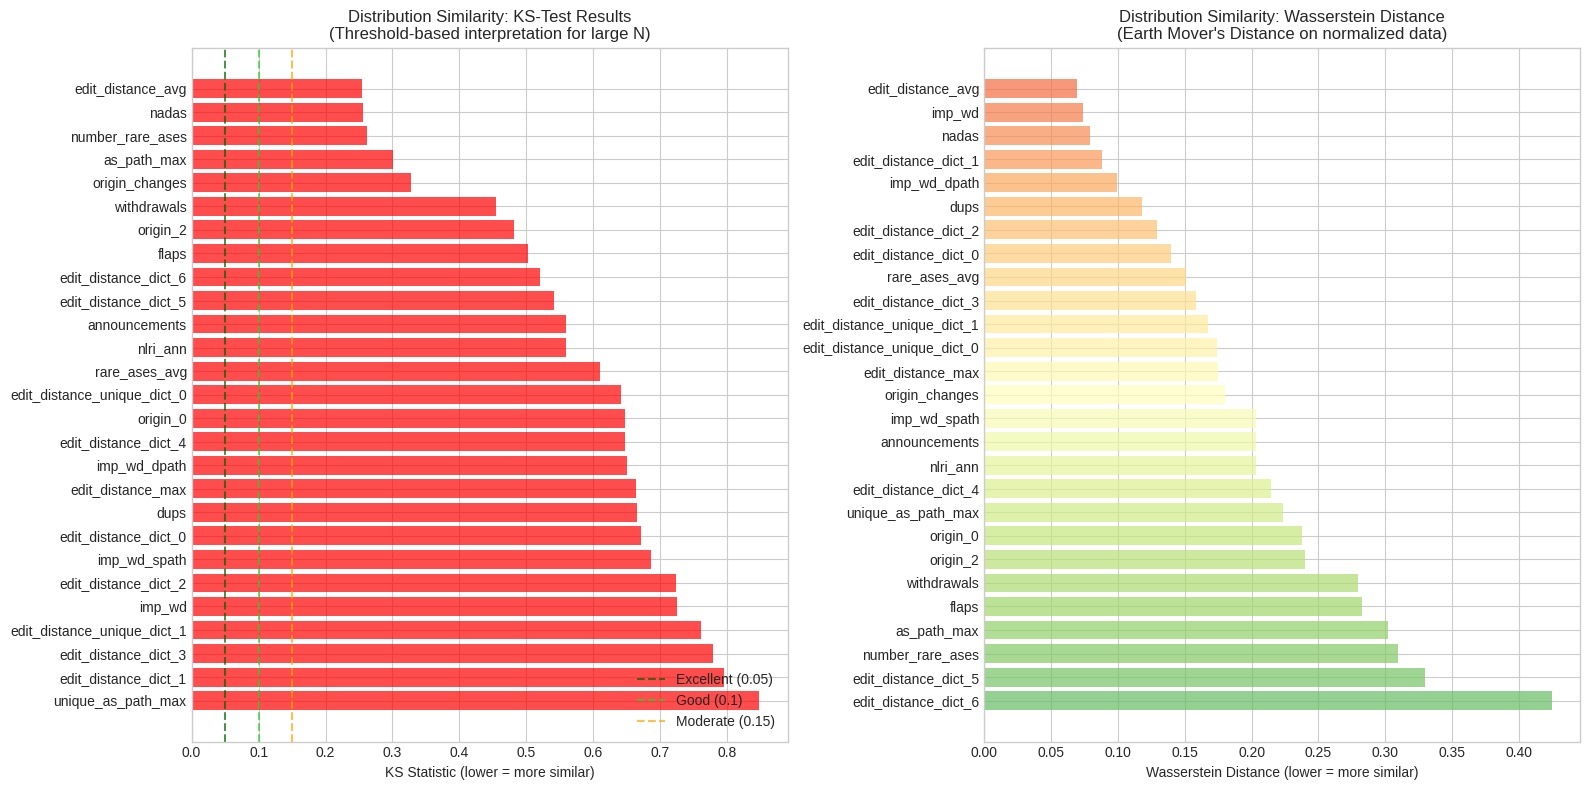

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_distribution_tests.png


In [167]:
# Visualize KS statistics with improved interpretation
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left plot: KS Statistics
ax1 = axes[0]
colors_ks = {
    'Excellent': 'darkgreen',
    'Good': 'limegreen',
    'Moderate': 'orange',
    'Poor': 'red'
}
bar_colors = [colors_ks[level] for level in ks_df['similarity_level']]
bars = ax1.barh(ks_df['feature'], ks_df['ks_statistic'], color=bar_colors, alpha=0.7)

ax1.axvline(x=KS_EXCELLENT_THRESHOLD, color='darkgreen', linestyle='--', alpha=0.7, label=f'Excellent ({KS_EXCELLENT_THRESHOLD})')
ax1.axvline(x=KS_GOOD_THRESHOLD, color='limegreen', linestyle='--', alpha=0.7, label=f'Good ({KS_GOOD_THRESHOLD})')
ax1.axvline(x=KS_MODERATE_THRESHOLD, color='orange', linestyle='--', alpha=0.7, label=f'Moderate ({KS_MODERATE_THRESHOLD})')
ax1.set_xlabel('KS Statistic (lower = more similar)')
ax1.set_title('Distribution Similarity: KS-Test Results\n(Threshold-based interpretation for large N)')
ax1.legend(loc='lower right')

# Right plot: Wasserstein Distance
ax2 = axes[1]
ks_df_sorted_wd = ks_df.sort_values('wasserstein_distance', ascending=False)
colors_wd = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(ks_df_sorted_wd)))
ax2.barh(ks_df_sorted_wd['feature'], ks_df_sorted_wd['wasserstein_distance'], color=colors_wd, alpha=0.7)
ax2.set_xlabel('Wasserstein Distance (lower = more similar)')
ax2.set_title('Distribution Similarity: Wasserstein Distance\n(Earth Mover\'s Distance on normalized data)')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/improved_v2_distribution_tests_synthetic_SMOTE.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/improved_v2_distribution_tests.png")

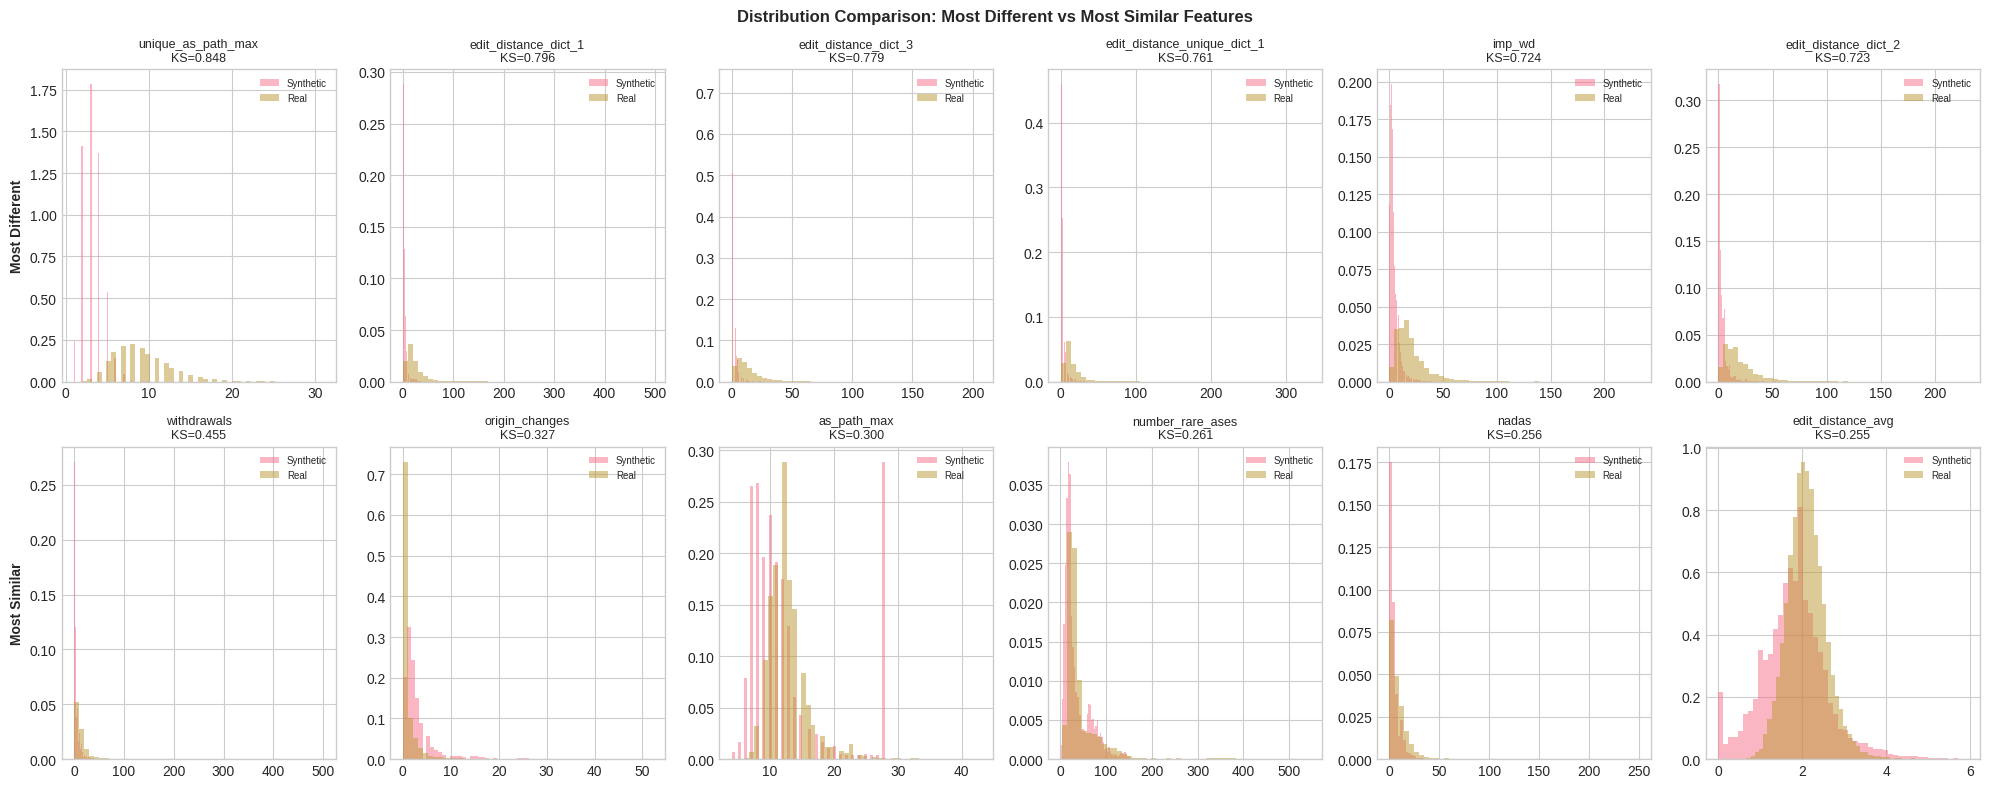

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_distribution_comparison.png


In [168]:
# Plot distributions for selected features
n_features_to_plot = 6

# Most different (highest KS statistic)
most_different = ks_df.head(n_features_to_plot)['feature'].tolist()
# Most similar (lowest KS statistic)
most_similar = ks_df.tail(n_features_to_plot)['feature'].tolist()

fig, axes = plt.subplots(2, n_features_to_plot, figsize=(20, 8))

# Plot most different
for i, col in enumerate(most_different):
    ax = axes[0, i]
    ax.hist(df_synthetic[col], bins=50, alpha=0.5, label='Synthetic', density=True)
    ax.hist(df_real[col], bins=50, alpha=0.5, label='Real', density=True)
    ks_val = ks_df[ks_df['feature'] == col]['ks_statistic'].values[0]
    ax.set_title(f'{col}\nKS={ks_val:.3f}', fontsize=9)
    ax.legend(fontsize=7)
    if i == 0:
        ax.set_ylabel('Most Different', fontsize=10, fontweight='bold')

# Plot most similar
for i, col in enumerate(most_similar):
    ax = axes[1, i]
    ax.hist(df_synthetic[col], bins=50, alpha=0.5, label='Synthetic', density=True)
    ax.hist(df_real[col], bins=50, alpha=0.5, label='Real', density=True)
    ks_val = ks_df[ks_df['feature'] == col]['ks_statistic'].values[0]
    ax.set_title(f'{col}\nKS={ks_val:.3f}', fontsize=9)
    ax.legend(fontsize=7)
    if i == 0:
        ax.set_ylabel('Most Similar', fontsize=10, fontweight='bold')

plt.suptitle('Distribution Comparison: Most Different vs Most Similar Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/improved_v2_distribution_comparison_synthetic_SMOTE.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/improved_v2_distribution_comparison.png")

## 5. Correlation Structure Analysis

In [169]:
# Calculate correlation matrices
corr_synthetic = df_synthetic.corr()
corr_real = df_real.corr()

# Absolute difference in correlations
corr_diff = abs(corr_synthetic - corr_real)

print("Correlation Matrix Comparison")
print("=" * 60)
print(f"Mean absolute correlation difference: {corr_diff.values.mean():.4f}")
print(f"Max absolute correlation difference: {corr_diff.values.max():.4f}")
print(f"Median absolute correlation difference: {np.median(corr_diff.values):.4f}")

Correlation Matrix Comparison
Mean absolute correlation difference: 0.1212
Max absolute correlation difference: 0.6758
Median absolute correlation difference: 0.0957


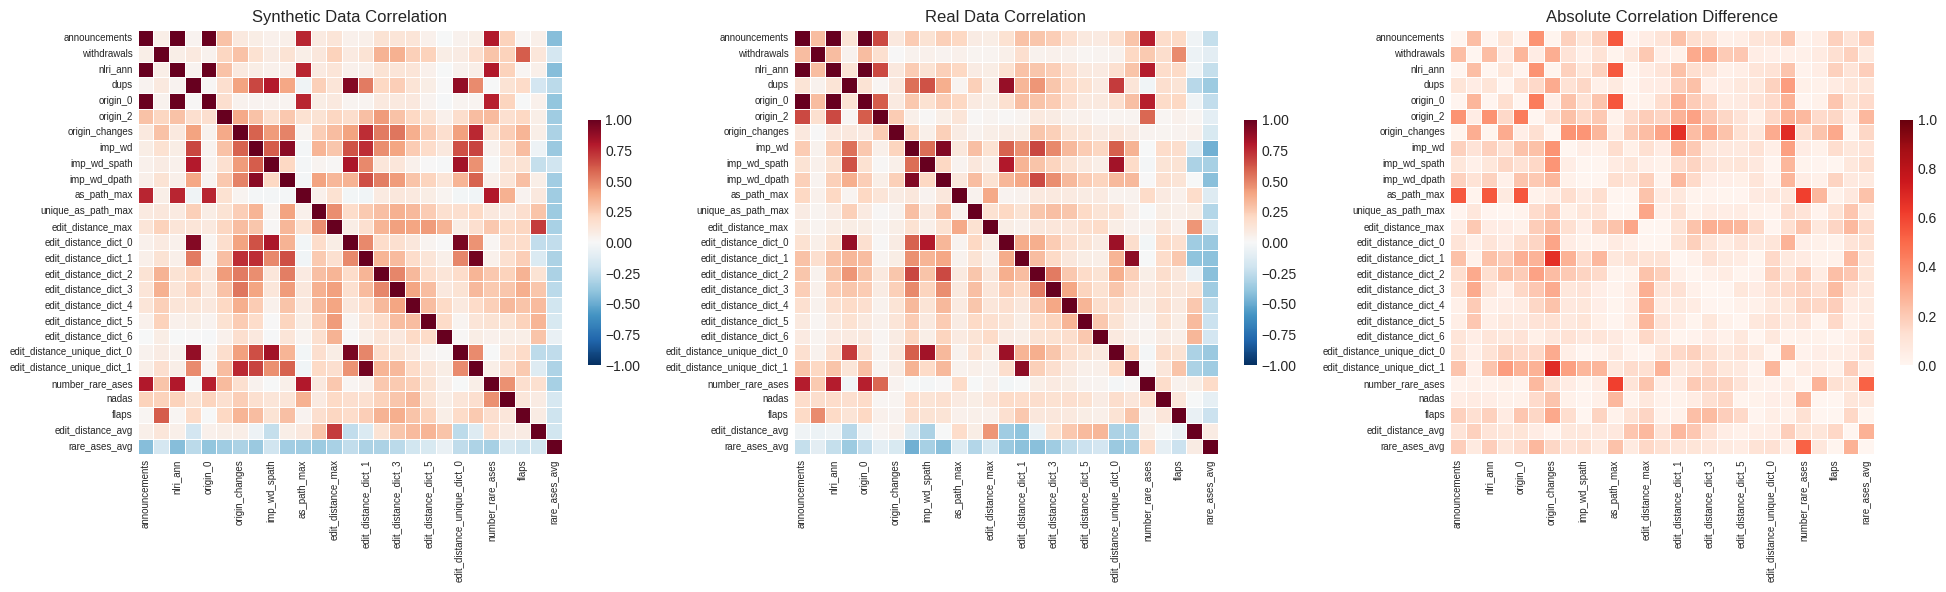

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_correlation_comparison.png


In [170]:
# Plot correlation matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Synthetic correlation
sns.heatmap(corr_synthetic, ax=axes[0], cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5},
            vmin=-1, vmax=1)
axes[0].set_title('Synthetic Data Correlation', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, fontsize=7)
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=7)

# Real correlation
sns.heatmap(corr_real, ax=axes[1], cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5},
            vmin=-1, vmax=1)
axes[1].set_title('Real Data Correlation', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, fontsize=7)
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=7)

# Difference
sns.heatmap(corr_diff, ax=axes[2], cmap='Reds',
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5},
            vmin=0, vmax=1)
axes[2].set_title('Absolute Correlation Difference', fontsize=12)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90, fontsize=7)
axes[2].set_yticklabels(axes[2].get_yticklabels(), fontsize=7)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/improved_v2_correlation_comparison_synthetic_SMOTE.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/improved_v2_correlation_comparison.png")

In [171]:
# Correlation of correlations (how similar are the correlation structures?)
def get_upper_triangle(matrix):
    return matrix.values[np.triu_indices(len(matrix), k=1)]

corr_syn_flat = get_upper_triangle(corr_synthetic)
corr_real_flat = get_upper_triangle(corr_real)

# Calculate correlation between correlation structures
structure_corr, structure_p = stats.pearsonr(corr_syn_flat, corr_real_flat)

# Also calculate Spearman (rank-based) correlation
structure_spearman, spearman_p = stats.spearmanr(corr_syn_flat, corr_real_flat)

print(f"\nCorrelation Structure Similarity")
print("=" * 40)
print(f"Pearson correlation of correlation matrices: {structure_corr:.4f}")
print(f"Spearman correlation of correlation matrices: {structure_spearman:.4f}")
print(f"\nInterpretation: {'High' if structure_corr > 0.8 else 'Moderate' if structure_corr > 0.5 else 'Low'} structural similarity")

# IMPROVED: Warn if correlation is negative (anti-aligned structures)
if structure_corr < 0:
    print(f"\n⚠️  WARNING: Negative correlation ({structure_corr:.4f}) indicates anti-aligned structures!")
    print(f"   This suggests the GAN may be learning inverted relationships.")


Correlation Structure Similarity
Pearson correlation of correlation matrices: 0.7819
Spearman correlation of correlation matrices: 0.5945

Interpretation: Moderate structural similarity


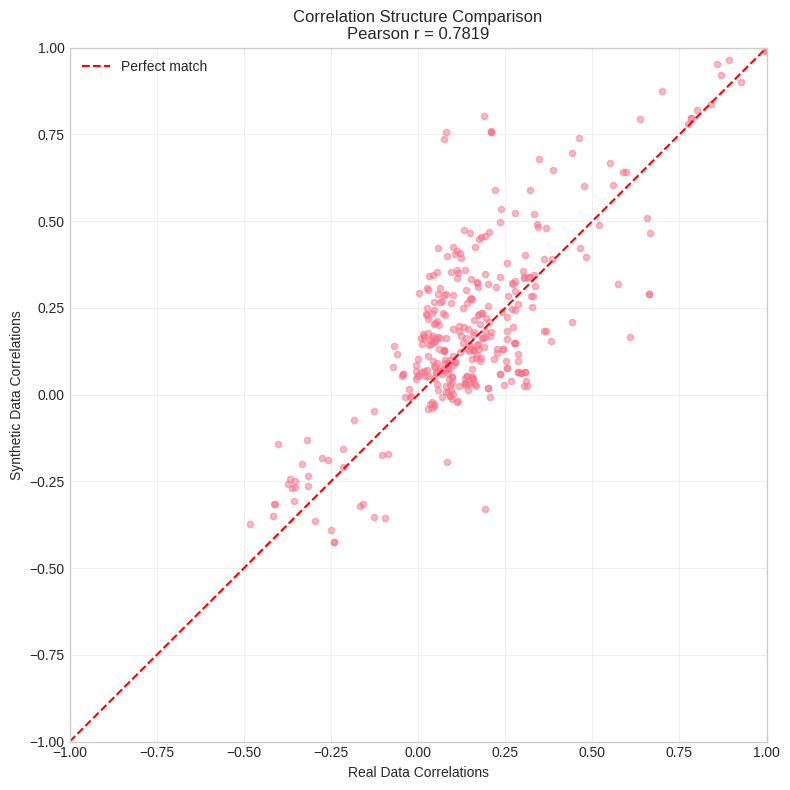

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_correlation_scatter.png


In [172]:
# Scatter plot of correlations
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(corr_real_flat, corr_syn_flat, alpha=0.5, s=20)
ax.plot([-1, 1], [-1, 1], 'r--', label='Perfect match')
ax.set_xlabel('Real Data Correlations')
ax.set_ylabel('Synthetic Data Correlations')
ax.set_title(f'Correlation Structure Comparison\nPearson r = {structure_corr:.4f}')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/improved_v2_correlation_scatter_synthetic_SMOTE.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/improved_v2_correlation_scatter.png")

## 6. Dimensionality Reduction (PCA & t-SNE)

In [173]:
# Combine and scale data
X_combined = np.vstack([X_synthetic, X_real])
labels = ['Synthetic'] * len(X_synthetic) + ['Real'] * len(X_real)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

print(f"Combined data shape: {X_combined.shape}")

Combined data shape: (40000, 27)


In [174]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

PCA explained variance ratio: [0.33854889 0.13789475]
Total variance explained: 47.64%


In [175]:
# IMPROVED: t-SNE with stratified sampling and stored indices for reproducibility
n_tsne_samples = min(5000, len(X_scaled))
n_each = n_tsne_samples // 2

np.random.seed(RANDOM_SEED)

# Stratified sampling: equal from synthetic and real
syn_indices = np.random.choice(len(X_synthetic), n_each, replace=False)
real_indices = np.random.choice(len(X_real), n_each, replace=False) + len(X_synthetic)
tsne_idx = np.concatenate([syn_indices, real_indices])
np.random.shuffle(tsne_idx)  # Shuffle to avoid any ordering bias

# IMPROVED: Store indices for reproducibility and diagnostics
tsne_indices_info = {
    'synthetic_indices': syn_indices.tolist(),
    'real_indices': (real_indices - len(X_synthetic)).tolist(),  # Original indices in real data
    'combined_indices': tsne_idx.tolist(),
    'random_seed': RANDOM_SEED,
    'n_synthetic': n_each,
    'n_real': n_each
}

# Save indices for strict reproducibility
with open(f'{OUTPUT_DIR}/improved_v2_tsne_indices.json', 'w') as f:
    json.dump(tsne_indices_info, f, indent=2)

tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled[tsne_idx])
labels_tsne = [labels[i] for i in tsne_idx]

print(f"t-SNE completed on {n_tsne_samples} samples")
print(f"  - Synthetic samples: {n_each}")
print(f"  - Real samples: {n_each}")
print(f"  - Indices saved to: {OUTPUT_DIR}/improved_v2_tsne_indices_synthetic_SMOTE.json")

t-SNE completed on 5000 samples
  - Synthetic samples: 2500
  - Real samples: 2500
  - Indices saved to: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_tsne_indices_synthetic_SMOTE.json


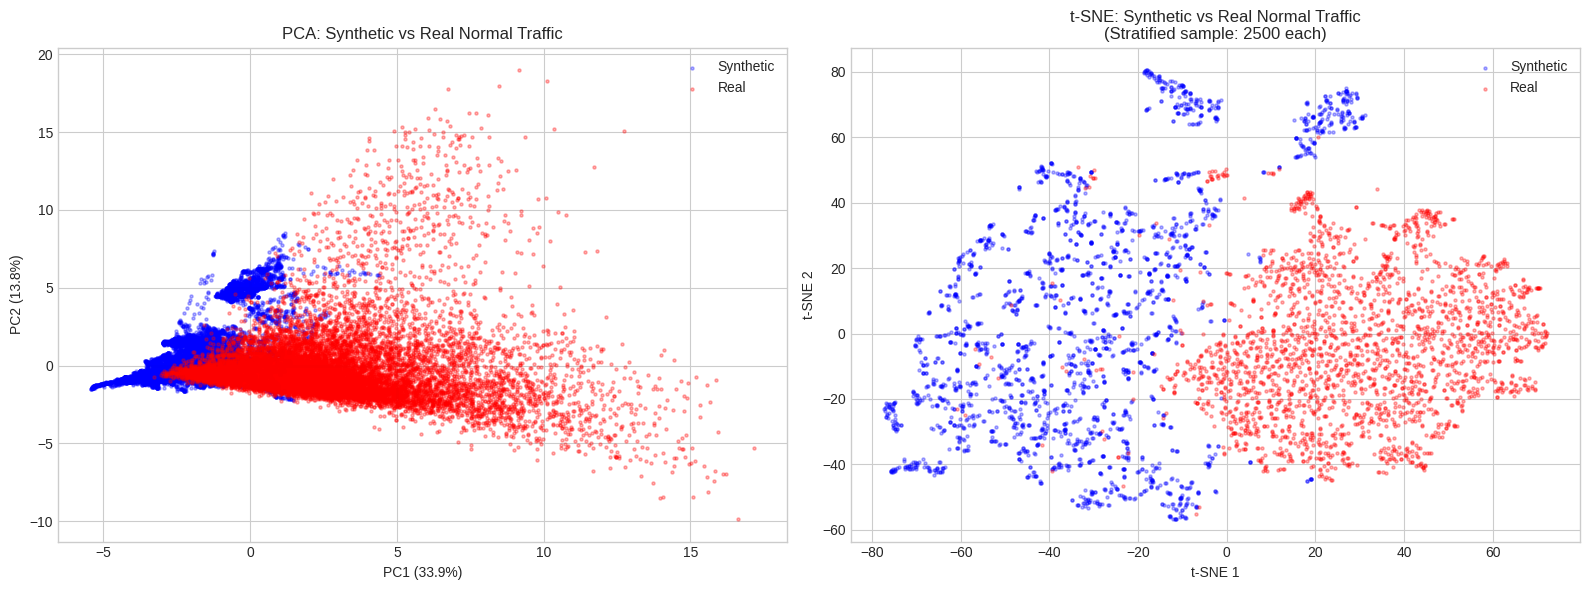

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_dimensionality_reduction.png


In [176]:
# Plot PCA and t-SNE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
ax1 = axes[0]
for label, color in [('Synthetic', 'blue'), ('Real', 'red')]:
    mask = np.array(labels) == label
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, alpha=0.3, s=5, label=label)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax1.set_title('PCA: Synthetic vs Real Normal Traffic')
ax1.legend()

# t-SNE plot
ax2 = axes[1]
for label, color in [('Synthetic', 'blue'), ('Real', 'red')]:
    mask = np.array(labels_tsne) == label
    ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color, alpha=0.3, s=5, label=label)
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_title(f't-SNE: Synthetic vs Real Normal Traffic\n(Stratified sample: {n_each} each)')
ax2.legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/improved_v2_dimensionality_reduction_synthetic_SMOTE.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/improved_v2_dimensionality_reduction.png")

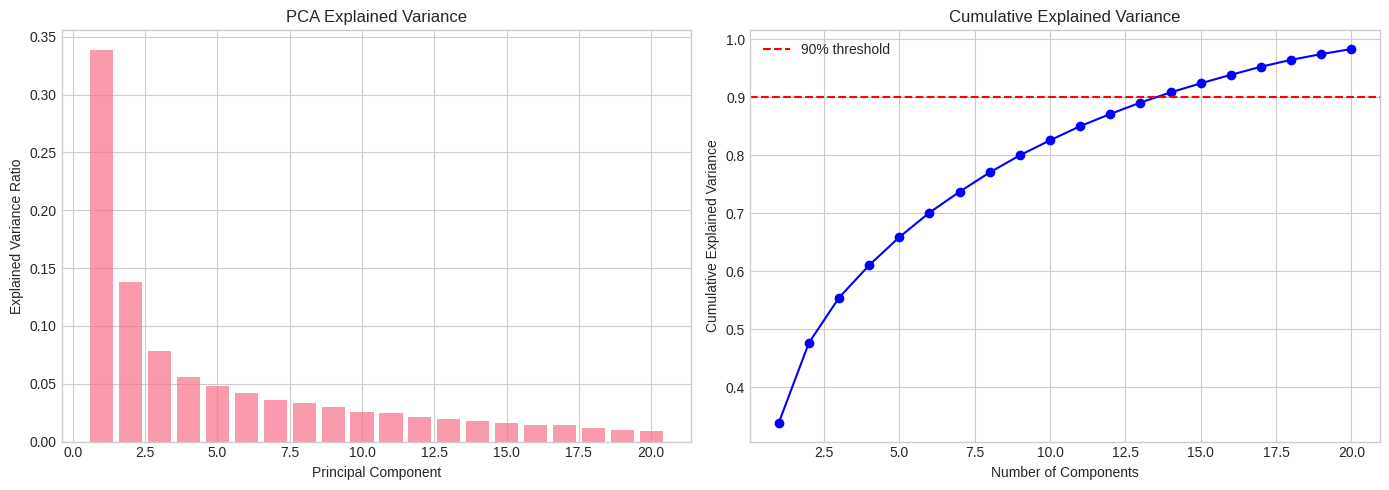

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_pca_variance.png


In [177]:
# PCA variance analysis
pca_full = PCA(n_components=min(20, len(feature_cols)))
pca_full.fit(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Explained variance
ax1 = axes[0]
ax1.bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
        pca_full.explained_variance_ratio_, alpha=0.7)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('PCA Explained Variance')

# Cumulative variance
ax2 = axes[1]
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
ax2.plot(range(1, len(cumsum) + 1), cumsum, 'b-o')
ax2.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/improved_v2_pca_variance_synthetic_SMOTE.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/improved_v2_pca_variance.png")

## 7. Additional Statistical Tests

In [178]:
# Mann-Whitney U test (non-parametric alternative to t-test)
mw_results = []

for col in feature_cols:
    stat, p_value = stats.mannwhitneyu(df_synthetic[col], df_real[col], alternative='two-sided')
    mw_results.append({
        'feature': col,
        'mw_statistic': stat,
        'p_value': p_value
    })

mw_df = pd.DataFrame(mw_results)

# IMPROVEMENT: Apply FDR correction to Mann-Whitney results
_, mw_adjusted_pvalues, _, _ = multipletests(mw_df['p_value'], method='fdr_bh')
mw_df['adjusted_p_value'] = mw_adjusted_pvalues
mw_df['similar'] = mw_adjusted_pvalues > ALPHA

mw_df = mw_df.sort_values('p_value', ascending=True)
mw_df.to_csv(f'{OUTPUT_DIR}/improved_v2_mw_results_synthetic_SMOTE.csv', index=False)

print("Mann-Whitney U Test Results (with FDR correction)")
print("=" * 60)
print(f"Features with similar medians (adjusted p > {ALPHA}): {mw_df['similar'].sum()}/{len(feature_cols)}")
print("\n")
print(mw_df.to_string(index=False))

Mann-Whitney U Test Results (with FDR correction)
Features with similar medians (adjusted p > 0.05): 0/27


                    feature  mw_statistic  p_value  adjusted_p_value  similar
              announcements    74999728.5      0.0               0.0    False
                      flaps    72787445.0      0.0               0.0    False
                      nadas   139060963.5      0.0               0.0    False
           number_rare_ases   151301078.0      0.0               0.0    False
edit_distance_unique_dict_1    24040772.5      0.0               0.0    False
edit_distance_unique_dict_0    46545281.0      0.0               0.0    False
       edit_distance_dict_6    92833690.5      0.0               0.0    False
       edit_distance_dict_5    76970750.5      0.0               0.0    False
       edit_distance_dict_4    48348846.0      0.0               0.0    False
       edit_distance_dict_3    19995480.5      0.0               0.0    False
       edit_distance_dict_2    283

In [179]:
# IMPROVED: Cohen's d effect size with capping for numeric stability
def cohens_d(group1, group2, cap=COHENS_D_CAP):
    """
    Calculate Cohen's d effect size with proper handling of edge cases.
    
    Args:
        group1, group2: Data arrays to compare
        cap: Maximum absolute value to return (for numeric stability)
    
    Returns:
        Cohen's d value, capped at [-cap, cap]
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    if pooled_std == 0:
        # Both groups have zero variance
        if group1.mean() == group2.mean():
            return 0.0  # Identical distributions
        else:
            # Different means with zero variance - return capped value with sign
            return cap if group1.mean() > group2.mean() else -cap
    
    d = (group1.mean() - group2.mean()) / pooled_std
    
    # Cap extreme values for numeric stability
    return np.clip(d, -cap, cap)

effect_sizes = []
for col in feature_cols:
    d = cohens_d(df_synthetic[col], df_real[col])
    
    # Interpret effect size using Cohen's guidelines
    # Treat any |d| > 2 as "Large" for practical purposes
    abs_d = abs(d)
    if abs_d < 0.2:
        interpretation = 'Negligible'
    elif abs_d < 0.5:
        interpretation = 'Small'
    elif abs_d < 0.8:
        interpretation = 'Medium'
    else:
        interpretation = 'Large'
    
    effect_sizes.append({
        'feature': col,
        'cohens_d': d,
        'abs_d': abs_d,
        'interpretation': interpretation,
        'capped': abs_d >= COHENS_D_CAP  # Flag if value was capped
    })

effect_df = pd.DataFrame(effect_sizes).sort_values('abs_d', ascending=False)
effect_df.to_csv(f'{OUTPUT_DIR}/improved_v2_effect_sizes_synthetic_SMOTE.csv', index=False)

print("Cohen's d Effect Size Analysis (IMPROVED with capping)")
print("=" * 60)
print(f"\nEffect Size Distribution:")
print(effect_df['interpretation'].value_counts())

# Warn about capped values
n_capped = effect_df['capped'].sum()
if n_capped > 0:
    print(f"\n⚠️  {n_capped} feature(s) had Cohen's d capped at ±{COHENS_D_CAP}")
    print(f"   Features: {effect_df[effect_df['capped']]['feature'].tolist()}")

print("\n")
print(effect_df.to_string(index=False))

Cohen's d Effect Size Analysis (IMPROVED with capping)

Effect Size Distribution:
interpretation
Large         15
Small          6
Medium         5
Negligible     1
Name: count, dtype: int64


                    feature  cohens_d    abs_d interpretation  capped
         unique_as_path_max -2.297426 2.297426          Large   False
          edit_distance_max -1.563496 1.563496          Large   False
       edit_distance_dict_3 -1.394455 1.394455          Large   False
                     imp_wd -1.345697 1.345697          Large   False
       edit_distance_dict_2 -1.306220 1.306220          Large   False
              rare_ases_avg  1.219429 1.219429          Large   False
edit_distance_unique_dict_0 -1.118184 1.118184          Large   False
               imp_wd_dpath -1.114177 1.114177          Large   False
       edit_distance_dict_0 -1.084006 1.084006          Large   False
       edit_distance_dict_1 -1.074995 1.074995          Large   False
                       dups -1.073815

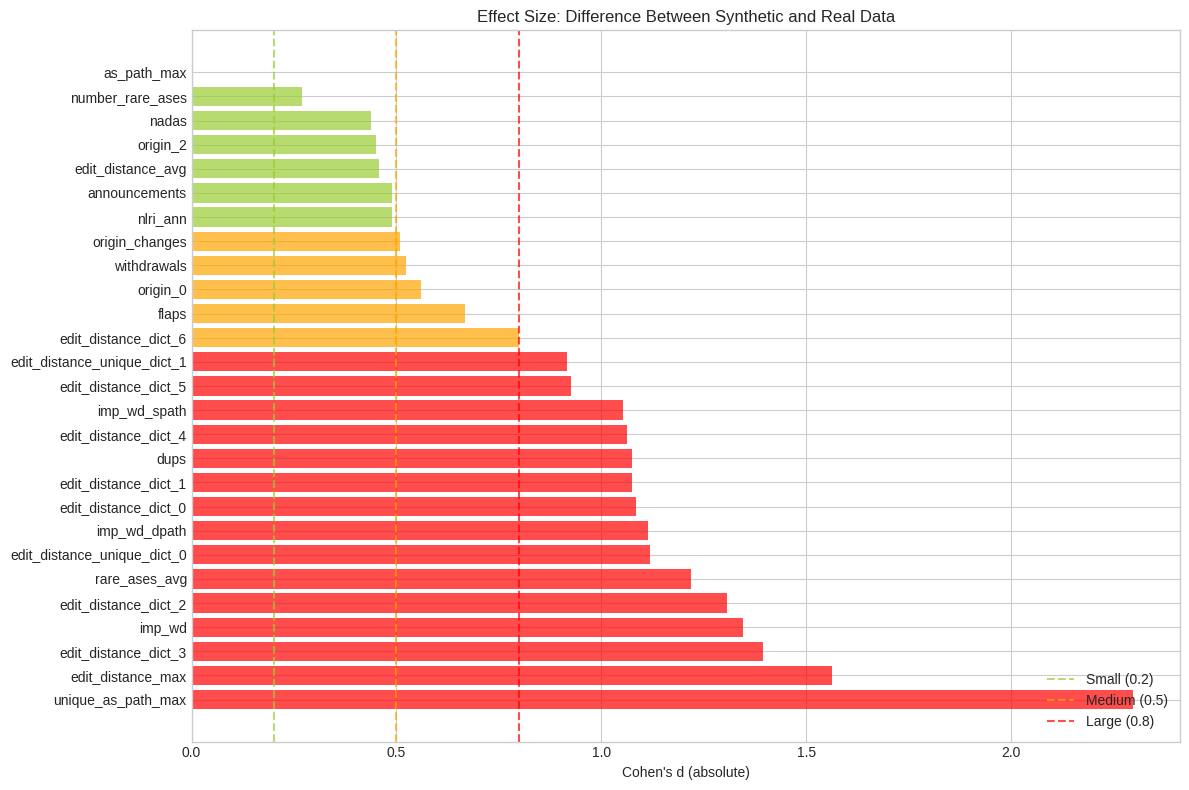

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_effect_sizes.png


In [180]:
# Visualize effect sizes
fig, ax = plt.subplots(figsize=(12, 8))

colors_effect = {
    'Negligible': 'green',
    'Small': 'yellowgreen', 
    'Medium': 'orange',
    'Large': 'red'
}
bar_colors = [colors_effect[interp] for interp in effect_df['interpretation']]

ax.barh(effect_df['feature'], effect_df['abs_d'], color=bar_colors, alpha=0.7)
ax.axvline(x=0.2, color='yellowgreen', linestyle='--', alpha=0.7, label='Small (0.2)')
ax.axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, label='Medium (0.5)')
ax.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='Large (0.8)')
ax.set_xlabel("Cohen's d (absolute)")
ax.set_title("Effect Size: Difference Between Synthetic and Real Data")
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/improved_v2_effect_sizes_synthetic_SMOTE.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/improved_v2_effect_sizes.png")

## 8. Improved Summary Report

In [181]:
# IMPROVED: Calculate better overall similarity score with safe correlation handling

# Component 1: Distribution Similarity - percentage of features with good/excellent similarity
good_or_better = (ks_df['similarity_level'].isin(['Excellent', 'Good'])).sum()
distribution_score = (good_or_better / len(feature_cols)) * 100

# REMOVED: distribution_score from mean KS (was unused, now removed to avoid confusion)
mean_ks = ks_df['ks_statistic'].mean()  # Keep for reporting only

# Component 2: Correlation Structure Similarity
# IMPROVED: Handle negative correlations properly by mapping [-1,1] to [0,100]
# This ensures anti-aligned structures get low scores, not negative scores
correlation_score = ((structure_corr + 1) / 2) * 100  # Maps -1→0, 0→50, 1→100

# Component 3: Effect Size Score
effect_counts = effect_df['interpretation'].value_counts()
negligible_count = effect_counts.get('Negligible', 0)
small_count = effect_counts.get('Small', 0)
medium_count = effect_counts.get('Medium', 0)
large_count = effect_counts.get('Large', 0)

# Weighted effect size score
effect_score = ((negligible_count * 1.0 + small_count * 0.75 + medium_count * 0.25 + large_count * 0.0) / len(feature_cols)) * 100

# Component 4: Wasserstein Distance Score
mean_wd = ks_df['wasserstein_distance'].mean()
wasserstein_score = max(0, (1 - mean_wd * 2)) * 100  # Scale: WD=0.5 → 0%, WD=0 → 100%

# IMPROVED Overall Score: weighted average
weights = {
    'distribution': 0.25,
    'correlation': 0.25,
    'effect_size': 0.30,
    'wasserstein': 0.20
}

overall_score = (
    distribution_score * weights['distribution'] +
    correlation_score * weights['correlation'] +
    effect_score * weights['effect_size'] +
    wasserstein_score * weights['wasserstein']
)

# Count problematic features for reporting
n_constant_syn_only = len(problematic_features['constant_synthetic_only'])
n_constant_real_only = len(problematic_features['constant_real_only'])
n_constant_both = len(problematic_features['constant_both'])

print("=" * 80)
print("PHASE 1: NORMAL TRAFFIC VALIDATION - IMPROVED SUMMARY REPORT v2")
print("=" * 80)

print(f"\n📊 DATA OVERVIEW")
print(f"   Synthetic normal samples: {len(synthetic_sampled):,}")
print(f"   Real normal samples: {len(real_sampled):,}")
print(f"   Total features: {len(feature_cols) + n_constant_both + n_constant_syn_only + n_constant_real_only}")
print(f"   Valid features for comparison: {len(feature_cols)}")

print(f"\n🔍 FEATURE QUALITY ISSUES")
print(f"   Constant in both (excluded): {n_constant_both}")
print(f"   ⚠️  Constant in synthetic only (GAN issue): {n_constant_syn_only}")
print(f"   ⚠️  Constant in real only (data issue): {n_constant_real_only}")

print(f"\n📈 DISTRIBUTION SIMILARITY")
print(f"   KS-Test (threshold-based for large N):")
print(f"     - Excellent (KS < {KS_EXCELLENT_THRESHOLD}): {(ks_df['similarity_level'] == 'Excellent').sum()}/{len(feature_cols)}")
print(f"     - Good (KS < {KS_GOOD_THRESHOLD}): {good_or_better}/{len(feature_cols)} ({distribution_score:.1f}%)")
print(f"     - Mean KS statistic: {mean_ks:.4f}")
print(f"   Wasserstein Distance:")
print(f"     - Mean: {mean_wd:.4f}")
print(f"     - Median: {ks_df['wasserstein_distance'].median():.4f}")

print(f"\n🔗 CORRELATION STRUCTURE")
print(f"   Pearson correlation of matrices: {structure_corr:.4f}")
print(f"   Spearman correlation of matrices: {structure_spearman:.4f}")
print(f"   Mean absolute correlation difference: {corr_diff.values.mean():.4f}")
if structure_corr < 0:
    print(f"   ⚠️  WARNING: Negative correlation indicates anti-aligned structures!")

print(f"\n📏 EFFECT SIZES (Cohen's d)")
for interp in ['Negligible', 'Small', 'Medium', 'Large']:
    count = effect_counts.get(interp, 0)
    print(f"   {interp}: {count} features")
if effect_df['capped'].sum() > 0:
    print(f"   ⚠️  {effect_df['capped'].sum()} feature(s) had values capped at ±{COHENS_D_CAP}")

print(f"\n🎯 IMPROVED OVERALL ASSESSMENT")
print(f"   Component Scores:")
print(f"     - Distribution (KS threshold): {distribution_score:.1f}/100 (weight: {weights['distribution']*100:.0f}%)")
print(f"     - Correlation Structure: {correlation_score:.1f}/100 (weight: {weights['correlation']*100:.0f}%)")
print(f"       (Note: mapped from r={structure_corr:.3f} using [−1,1]→[0,100])")
print(f"     - Effect Size: {effect_score:.1f}/100 (weight: {weights['effect_size']*100:.0f}%)")
print(f"     - Wasserstein Distance: {wasserstein_score:.1f}/100 (weight: {weights['wasserstein']*100:.0f}%)")
print(f"   ───────────────────────────────")
print(f"   OVERALL SIMILARITY: {overall_score:.1f}/100")

if overall_score >= 80:
    verdict = "✅ EXCELLENT - Synthetic data closely matches real traffic"
elif overall_score >= 70:
    verdict = "✅ GOOD - Synthetic data reasonably represents real traffic"
elif overall_score >= 50:
    verdict = "⚠️ MODERATE - Some features need improvement"
else:
    verdict = "❌ POOR - Significant differences detected"
print(f"\n   Verdict: {verdict}")

print(f"\n📋 FEATURES NEEDING ATTENTION:")

# Features with large effect size
large_effect = effect_df[effect_df['interpretation'] == 'Large']['feature'].tolist()
# Features with poor KS similarity
poor_ks = ks_df[ks_df['similarity_level'] == 'Poor']['feature'].tolist()
# Features constant in synthetic only (GAN not learning variance)
const_syn_features = [item['feature'] for item in problematic_features['constant_synthetic_only']]

attention_features = list(set(large_effect + poor_ks + const_syn_features))
if attention_features:
    for f in attention_features:
        reasons = []
        if f in large_effect:
            d_val = effect_df[effect_df['feature'] == f]['cohens_d'].values[0]
            reasons.append(f"Large effect (d={d_val:.3f})")
        if f in poor_ks:
            ks_val = ks_df[ks_df['feature'] == f]['ks_statistic'].values[0]
            reasons.append(f"Poor KS ({ks_val:.3f})")
        if f in const_syn_features:
            reasons.append("Constant in synthetic (GAN issue)")
        print(f"   • {f}: {', '.join(reasons)}")
else:
    print("   None - all features have acceptable similarity")

print("\n" + "=" * 80)

PHASE 1: NORMAL TRAFFIC VALIDATION - IMPROVED SUMMARY REPORT v2

📊 DATA OVERVIEW
   Synthetic normal samples: 20,000
   Real normal samples: 20,000
   Total features: 27
   Valid features for comparison: 27

🔍 FEATURE QUALITY ISSUES
   Constant in both (excluded): 0
   ⚠️  Constant in synthetic only (GAN issue): 0
   ⚠️  Constant in real only (data issue): 0

📈 DISTRIBUTION SIMILARITY
   KS-Test (threshold-based for large N):
     - Excellent (KS < 0.05): 0/27
     - Good (KS < 0.1): 0/27 (0.0%)
     - Mean KS statistic: 0.5751
   Wasserstein Distance:
     - Mean: 0.1947
     - Median: 0.1804

🔗 CORRELATION STRUCTURE
   Pearson correlation of matrices: 0.7819
   Spearman correlation of matrices: 0.5945
   Mean absolute correlation difference: 0.1212

📏 EFFECT SIZES (Cohen's d)
   Negligible: 1 features
   Small: 6 features
   Medium: 5 features
   Large: 15 features

🎯 IMPROVED OVERALL ASSESSMENT
   Component Scores:
     - Distribution (KS threshold): 0.0/100 (weight: 25%)
     - Cor

In [182]:
# Save detailed results to CSV
results_df = ks_df.merge(mw_df[['feature', 'mw_statistic', 'adjusted_p_value']], on='feature')
results_df = results_df.merge(effect_df[['feature', 'cohens_d', 'interpretation', 'capped']], on='feature')
results_df = results_df.merge(
    mean_diff.reset_index().rename(columns={'index': 'feature'})[['feature', 'synthetic_mean', 'real_mean', 'abs_diff', 'pct_diff']], 
    on='feature'
)

results_df.to_csv(f'{OUTPUT_DIR}/improved_v2_detailed_results_synthetic_SMOTE.csv', index=False)
print(f"Detailed results saved to: {OUTPUT_DIR}/improved_v2_detailed_results.csv")

# Display final table
print("\nFinal Results Table:")
results_df

Detailed results saved to: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_detailed_results.csv

Final Results Table:


,feature,ks_statistic,ks_pvalue,wasserstein_distance,similarity_level,similar_by_threshold,adjusted_pvalue,similar_by_adjusted_pvalue,mw_statistic,adjusted_p_value,cohens_d,interpretation,capped,synthetic_mean,real_mean,abs_diff,pct_diff
0,unique_as_path_max,0.84755,0.0,0.223760,Poor,False,0.0,False,9908459.5,0.0,-2.297426,Large,False,3.230300,9.273600,6.043300,65.166710
1,edit_distance_dict_1,0.79580,0.0,0.088370,Poor,False,0.0,False,18499756.0,0.0,-1.074995,Large,False,3.069300,25.745100,22.675800,88.078120
2,edit_distance_dict_3,0.77855,0.0,0.158653,Poor,False,0.0,False,19995480.5,0.0,-1.394455,Large,False,1.525700,13.702650,12.176950,88.865657
3,edit_distance_unique_dict_1,0.76095,0.0,0.167481,Poor,False,0.0,False,24040772.5,0.0,-0.916639,Large,False,2.508650,16.347400,13.838750,84.654135
4,imp_wd,0.72445,0.0,0.074140,Poor,False,0.0,False,26667732.5,0.0,-1.345697,Large,False,4.103200,21.069250,16.966050,80.525173
5,edit_distance_dict_2,0.72270,0.0,0.129433,Poor,False,0.0,False,28340392.0,0.0,-1.306220,Large,False,3.492650,20.378200,16.885550,82.860851
6,imp_wd_spath,0.68635,0.0,0.203261,Poor,False,0.0,False,42946940.0,0.0,-1.052292,Large,False,0.914600,6.063950,5.149350,84.917422
7,edit_distance_dict_0,0.67135,0.0,0.139972,Poor,False,0.0,False,41619494.5,0.0,-1.084006,Large,False,1.453600,8.737950,7.284350,83.364519
8,dups,0.66565,0.0,0.117680,Poor,False,0.0,False,39593468.5,0.0,-1.073815,Large,False,1.649750,11.452000,9.802250,85.594219
9,edit_distance_max,0.66380,0.0,0.174980,Poor,False,0.0,False,42148518.5,0.0,-1.563496,Large,False,3.544900,7.004900,3.460000,49.393996


In [183]:
# Save summary statistics
summary_stats = pd.DataFrame({
    'Metric': [
        'Synthetic Samples',
        'Real Samples', 
        'Valid Features Compared',
        'Constant in Both (Excluded)',
        'Constant in Synthetic Only (GAN Issue)',
        'Constant in Real Only',
        'KS Excellent Features',
        'KS Good or Better Features',
        'Mean KS Statistic',
        'Mean Wasserstein Distance',
        'Correlation Similarity (Pearson)',
        'Correlation Similarity (Spearman)',
        'Negligible Effect Features',
        'Small Effect Features',
        'Medium Effect Features',
        'Large Effect Features',
        'Distribution Score',
        'Correlation Score (mapped)',
        'Effect Size Score',
        'Wasserstein Score',
        'Overall Similarity Score'
    ],
    'Value': [
        len(synthetic_sampled),
        len(real_sampled),
        len(feature_cols),
        n_constant_both,
        n_constant_syn_only,
        n_constant_real_only,
        (ks_df['similarity_level'] == 'Excellent').sum(),
        good_or_better,
        f"{mean_ks:.4f}",
        f"{mean_wd:.4f}",
        f"{structure_corr:.4f}",
        f"{structure_spearman:.4f}",
        effect_counts.get('Negligible', 0),
        effect_counts.get('Small', 0),
        effect_counts.get('Medium', 0),
        effect_counts.get('Large', 0),
        f"{distribution_score:.1f}/100",
        f"{correlation_score:.1f}/100",
        f"{effect_score:.1f}/100",
        f"{wasserstein_score:.1f}/100",
        f"{overall_score:.1f}/100"
    ]
})

summary_stats.to_csv(f'{OUTPUT_DIR}/improved_v2_summary_synthetic_SMOTE.csv', index=False)
print(f"Summary saved to: {OUTPUT_DIR}/improved_v2_summary.csv")
summary_stats

Summary saved to: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_summary.csv


,Metric,Value
0,Synthetic Samples,20000
1,Real Samples,20000
2,Valid Features Compared,27
3,Constant in Both (Excluded),0
4,Constant in Synthetic Only (GAN Issue),0
5,Constant in Real Only,0
6,KS Excellent Features,0
7,KS Good or Better Features,0
8,Mean KS Statistic,0.5751
9,Mean Wasserstein Distance,0.1947


## 9. Quality Assessment Visualization

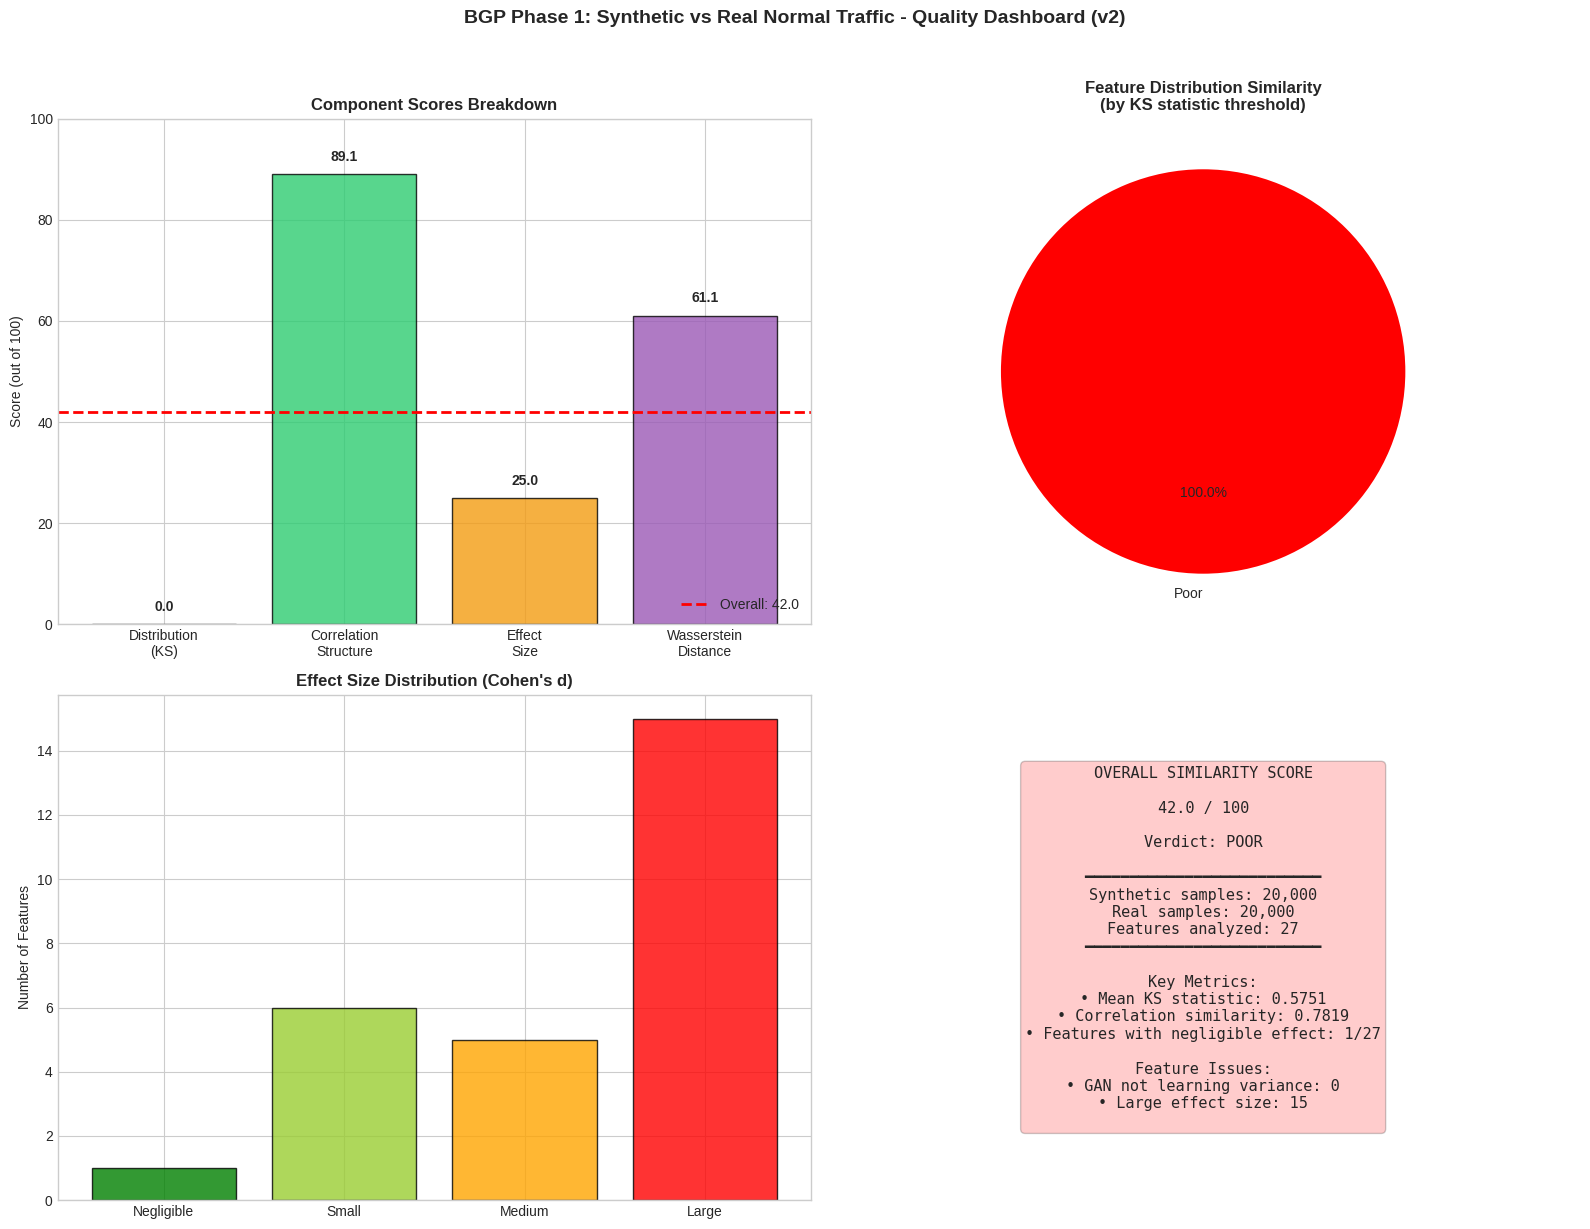

Saved: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_quality_dashboard.png


In [184]:
# Create a comprehensive quality dashboard
fig = plt.figure(figsize=(16, 12))

# 1. Score breakdown (bar chart)
ax1 = fig.add_subplot(2, 2, 1)
scores = [distribution_score, correlation_score, effect_score, wasserstein_score]
score_names = ['Distribution\n(KS)', 'Correlation\nStructure', 'Effect\nSize', 'Wasserstein\nDistance']
colors_scores = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6']

bars = ax1.bar(score_names, scores, color=colors_scores, alpha=0.8, edgecolor='black')
ax1.axhline(y=overall_score, color='red', linestyle='--', linewidth=2, label=f'Overall: {overall_score:.1f}')
ax1.set_ylabel('Score (out of 100)')
ax1.set_title('Component Scores Breakdown', fontweight='bold')
ax1.set_ylim(0, 100)
ax1.legend(loc='lower right')

# Add score labels on bars
for bar, score in zip(bars, scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{score:.1f}', ha='center', va='bottom', fontweight='bold')

# 2. KS statistic distribution
ax2 = fig.add_subplot(2, 2, 2)
similarity_counts = ks_df['similarity_level'].value_counts()
colors_sim = {'Excellent': 'darkgreen', 'Good': 'limegreen', 'Moderate': 'orange', 'Poor': 'red'}
pie_colors = [colors_sim[level] for level in similarity_counts.index]
ax2.pie(similarity_counts.values, labels=similarity_counts.index, colors=pie_colors,
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Feature Distribution Similarity\n(by KS statistic threshold)', fontweight='bold')

# 3. Effect size distribution
ax3 = fig.add_subplot(2, 2, 3)
effect_order = ['Negligible', 'Small', 'Medium', 'Large']
effect_colors = ['green', 'yellowgreen', 'orange', 'red']
effect_values = [effect_counts.get(e, 0) for e in effect_order]
ax3.bar(effect_order, effect_values, color=effect_colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Number of Features')
ax3.set_title('Effect Size Distribution (Cohen\'s d)', fontweight='bold')

# 4. Overall verdict
ax4 = fig.add_subplot(2, 2, 4)
ax4.axis('off')

# Determine color based on score
if overall_score >= 80:
    verdict_color = 'darkgreen'
    verdict_text = 'EXCELLENT'
elif overall_score >= 70:
    verdict_color = 'green'
    verdict_text = 'GOOD'
elif overall_score >= 50:
    verdict_color = 'orange'
    verdict_text = 'MODERATE'
else:
    verdict_color = 'red'
    verdict_text = 'POOR'

# Create text box
textstr = f"""OVERALL SIMILARITY SCORE

{overall_score:.1f} / 100

Verdict: {verdict_text}

━━━━━━━━━━━━━━━━━━━━━━━━━━
Synthetic samples: {len(synthetic_sampled):,}
Real samples: {len(real_sampled):,}
Features analyzed: {len(feature_cols)}
━━━━━━━━━━━━━━━━━━━━━━━━━━

Key Metrics:
• Mean KS statistic: {mean_ks:.4f}
• Correlation similarity: {structure_corr:.4f}
• Features with negligible effect: {negligible_count}/{len(feature_cols)}

Feature Issues:
• GAN not learning variance: {n_constant_syn_only}
• Large effect size: {large_count}
"""

ax4.text(0.5, 0.5, textstr, transform=ax4.transAxes, fontsize=11,
         verticalalignment='center', horizontalalignment='center',
         bbox=dict(boxstyle='round', facecolor=verdict_color, alpha=0.2),
         family='monospace')

plt.suptitle('BGP Phase 1: Synthetic vs Real Normal Traffic - Quality Dashboard (v2)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/improved_v2_quality_dashboard_synthetic_SMOTE.png', dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR}/improved_v2_quality_dashboard.png")

In [185]:
# Save problematic features report
problematic_report = {
    'constant_both': problematic_features['constant_both'],
    'constant_synthetic_only': problematic_features['constant_synthetic_only'],
    'constant_real_only': problematic_features['constant_real_only'],
    'large_effect_size': large_effect,
    'poor_ks_similarity': poor_ks
}

with open(f'{OUTPUT_DIR}/improved_v2_problematic_features_synthetic_SMOTE.json', 'w') as f:
    json.dump(problematic_report, f, indent=2, default=str)

print(f"Problematic features report saved to: {OUTPUT_DIR}/improved_v2_problematic_features.json")

Problematic features report saved to: /home/smotaali/BGP_Traffic_Generation/results/SMOTE_enhanced/normal//improved_v2_problematic_features.json
